# Comparison between classifier algorithms with emphasis on ensemble algorithms with a custom implementation of the AdaBoost algorithm

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#real data
from sklearn import datasets

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Bagging
from sklearn.ensemble import BaggingClassifier
#Random Forest
from sklearn.ensemble import RandomForestClassifier
#Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
#XGboost
from xgboost import XGBClassifier
#single tree
from sklearn.tree import DecisionTreeClassifier

from scipy.stats import chi2
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

np.random.seed(1)
n_reps = 100

In [2]:
#cancer dataset
cancer_data, data_labels = datasets.load_breast_cancer( return_X_y=True)
cancer_data = pd.DataFrame(cancer_data)

scaler = StandardScaler()
cancer_data = scaler.fit_transform(cancer_data)

print("y bincount: "+str(np.bincount(data_labels)))
print("data shape: "+str(cancer_data.shape))

y bincount: [212 357]
data shape: (569, 30)


In [3]:
class AdaBoost:
    def __init__(self, B):
        self.B = B
        self.ensemble_forest = []
        self.ensemble_beta = np.zeros(B)

    def fit( self, X, y):
        n = X.shape[0]
        weights = np.ones(n) / n

        for k in range(self.B):
            DTC_k = DecisionTreeClassifier( max_depth=2).fit(X, y, sample_weight=weights)

            #int: 1-wrong pred, 0-correct pred
            wrong_pred = (DTC_k.predict(X) != y).astype(int)

            #weighted error
            error_k = (wrong_pred * weights).sum()

            beta_k = error_k / (1-error_k)

            self.ensemble_forest.append(DTC_k)
            self.ensemble_beta[k] = beta_k

            if error_k == 0:
                print(str(k)+"<"+str(self.B)+": END - error eq 0")
                break

            #if coreectly predicted (1-wrong_pred) then
            #new_weights = weights * beta_k = weights + weights * (beta_k-1)
            #else new_weights = weights = weights + 0
            weights += (weights * (beta_k-1) ) * (1-wrong_pred)

            #normilaze weights
            weights = weights / weights.sum()
        
    def predict_proba( self, X):
        B_true = len(self.ensemble_forest)
        n = len(X)
        ensemble_anws = np.zeros((n,B_true))
        #ensemble_anws_column_k = predcition of k tree in ensemble
        for k in range(B_true):
            ensemble_anws[:,k] = self.ensemble_forest[k].predict(X)
        
        #ensemble_anws_1 weighted anwsers for 1
        #ensemble_anws_0 weighted anwsers for 0
        ensemble_anws_1 = ensemble_anws @ np.log(1/self.ensemble_beta)
        ensemble_anws_0 = (1-ensemble_anws) @ np.log(1/self.ensemble_beta)

        ensemble_anws_1_prob = ensemble_anws_1 / (ensemble_anws_1+ensemble_anws_0)
        
        return ensemble_anws_1_prob
    
    def predict( self, X):
        return self.predict_proba( X) > 0.5
    

In [4]:
def artificial_data(n):
    X = np.random.normal(size=(n,10))
    #sum(X^2) > chi2.median(df=10)
    y = ( np.sum(X*X, axis=1) > chi2.median(10) ).astype(int)
    return X, y

X_2k, y_2k = artificial_data(2000)
X_10k, y_10k = artificial_data(10000)

In [5]:
def methods_l():
    methods_list = {
        "Bagging_3": BaggingClassifier(n_estimators=3),
        "Bagging_10": BaggingClassifier(n_estimators=10),
        "Bagging_30": BaggingClassifier(n_estimators=30),
        "Bagging_100": BaggingClassifier(n_estimators=100),
        "Bagging_300": BaggingClassifier(n_estimators=300),
        "AdaBoost_3": AdaBoost(3),
        "AdaBoost_10": AdaBoost(10),
        "AdaBoost_30": AdaBoost(30),
        "AdaBoost_100": AdaBoost(100),
        "AdaBoost_300": AdaBoost(300),
        "Random Forest": RandomForestClassifier(),
        "Single tree": DecisionTreeClassifier(),
        "Decision stump": DecisionTreeClassifier( max_depth=1),
        "Gradient Boosting": GradientBoostingClassifier(),
        "xgboost": XGBClassifier()
    }
    return methods_list

metrics = {
    "ACC": ("label", accuracy_score),
    "F1": ("label", f1_score),
    "ROC AUC": ("proba", roc_auc_score),
}

results = []

In [6]:
def add_results_for_data( results, X, y, data_name):

    for i in range(n_reps):
        print("#",end="")
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=0.8, random_state=np.random.randint(1e9)
        )

        methods = methods_l()

        for method_name, model in methods.items():
            model.fit(X_train, y_train)

            for metric_name, (metric_type, metric) in metrics.items():
                if metric_type == "label":
                    y_pred = model.predict(X_test)
                elif metric_type == "proba":
                    y_pred = model.predict_proba(X_test)

                    if len(y_pred.shape)==2:
                        y_pred = y_pred[:,1]

                value = metric(y_test, y_pred)
                results.append([data_name, i, method_name, metric_name, value])
    print("\n")
    return results

print("X_2k")
results = add_results_for_data( results, X_2k, y_2k, "X_2k")
print("X_10k")
results = add_results_for_data( results, X_10k, y_10k, "X_10k")
print("cancer")
results = add_results_for_data( results, cancer_data, data_labels, "cancer")

X_2k
####################################################################################################

X_10k
####################################################################################################

cancer
####################################################################################################



In [7]:
results = pd.DataFrame(
    results, columns=["Dataset", "Repeat", "Method", "Metric", "Value"]
)

model_to_compare = ["Bagging_300", "AdaBoost_300", "Random Forest", "Single tree", 
                    "Decision stump", "Gradient Boosting", "xgboost"]
model_size_to_compare = ["Bagging_3", "Bagging_10", "Bagging_30", "Bagging_100", "Bagging_300", 
                         "AdaBoost_3", "AdaBoost_10", "AdaBoost_30", "AdaBoost_100", "AdaBoost_300"]

In [8]:
def plot_results( data_name, list_of_models_to_compare_str):
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 5)
    sns.boxplot(
        data = results[np.logical_and( 
            results["Method"].isin(list_of_models_to_compare_str), 
            (results["Dataset"] == data_name) 
        )], 
        x="Method", hue="Metric", y="Value", ax=ax
    )
    sns.move_legend(ax, loc="lower right")
    ax.set_title(f"Classification metrics for {data_name} dataset ({n_reps} samples per boxplot)")
    plt.tight_layout()
    plt.plot()

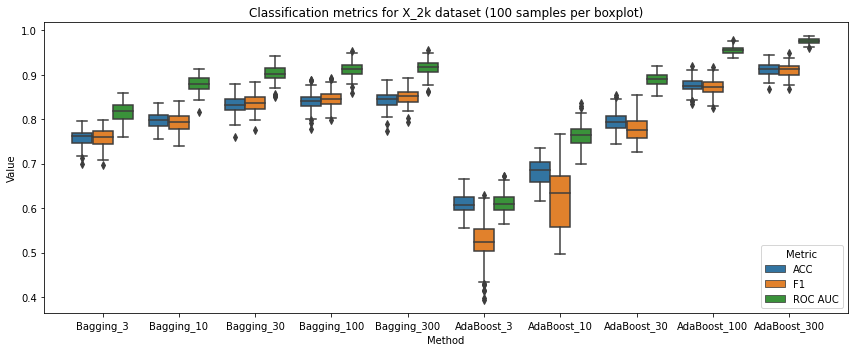

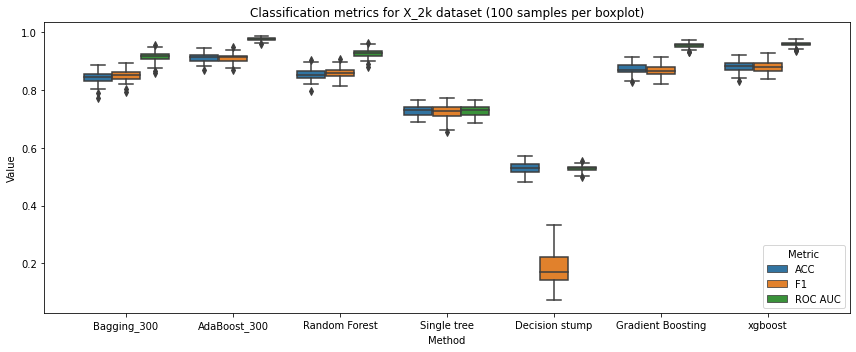

In [9]:
plot_results( "X_2k", model_size_to_compare)
plot_results( "X_2k", model_to_compare)

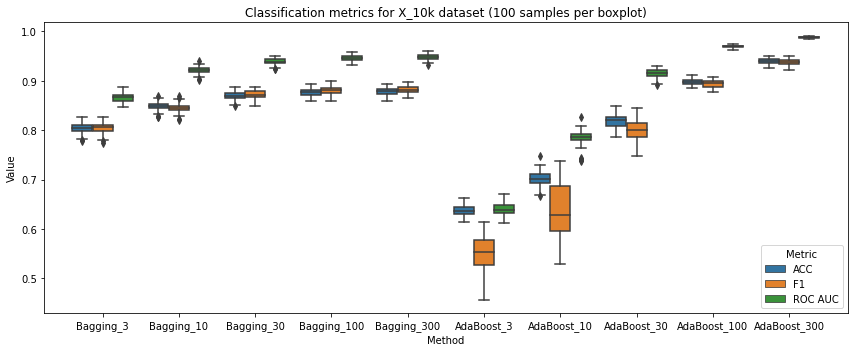

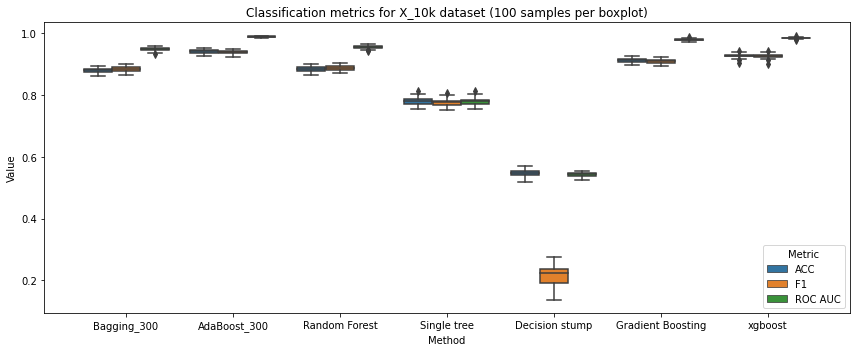

In [10]:
plot_results( "X_10k", model_size_to_compare)
plot_results( "X_10k", model_to_compare)

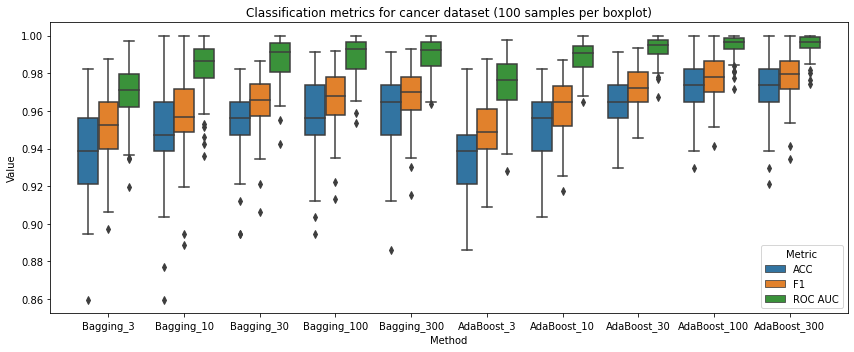

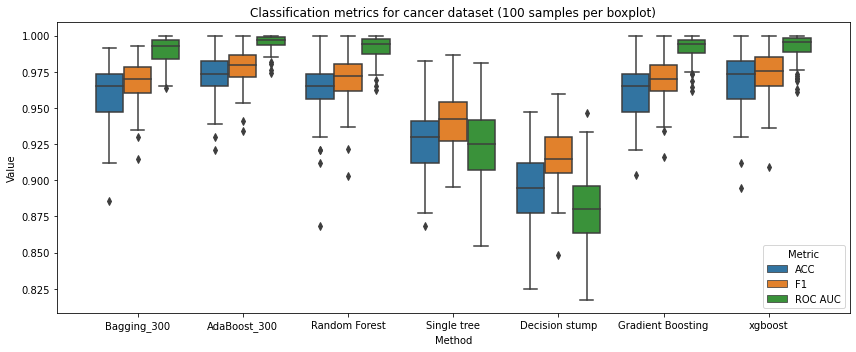

In [11]:
plot_results( "cancer", model_size_to_compare)
plot_results( "cancer", model_to_compare)